# Connecting world electricity production with air pollution
## Micah Buuck
### 5/23/2023

It is reasonable to assume that particularly dirty energy production, e.g. coal, will be associated with higher death rates from air pollution. This notebook investigates the relationship between different kinds of electricity production and deaths from air pollution using data from Our World in Data. I find that the relationship between electricity production and air pollution deaths is not quite so straightforward.

In [1]:
# Basic imports
import warnings
from decimal import Decimal
from bisect import bisect_left

# Data structure imports
import geopandas as gpd
import pandas as pd

# Computational/modelling imports
import numpy as np
import scipy.special
import statsmodels.api as sm
from statsmodels.tools.sm_exceptions import MissingDataError

# Plotting imports
from matplotlib import rcParams
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm, SymLogNorm, LogNorm
import seaborn as sns

# Set the Seaborn theme and default fonts
sns.set_theme(context='notebook', style='ticks', font_scale=1.2, font='Segoe UI')
rcParams['font.family'].insert(0, 'Segoe UI')
rcParams['mathtext.fontset'] = 'custom'
rcParams['mathtext.rm'] = 'Segoe UI'
rcParams['mathtext.it'] = 'Segoe UI:italic'
rcParams['mathtext.bf'] = 'Segoe UI:bold'
rcParams['mathtext.sf'] = 'Segoe UI'
rcParams['mathtext.tt'] = 'Segoe UI'
rcParams['mathtext.cal'] = 'Segoe UI'

### Load and prepare data

I have two shapefile sets, but they both have issues. The one in `world_shapefiles` is old and is missing at least one new country (South Sudan). The one in `world_countries_generalized` is better, but for some reason it does not separate China from Taiwan... So I'll combine them by hand by loading the geometries for China and Taiwan from `world_shapefiles` into `world_countries_generalized`.

In [2]:
countries = gpd.read_file("world_countries_generalized/World_Countries__Generalized_.shp")
countries.rename(columns={'COUNTRY':'NAME'}, inplace=True)

ERROR 1: PROJ: proj_create_from_database: Open of /home/mbuuck/miniconda3/envs/electricity_pollution/share/proj failed


Here is a sample of `world_countries_generalized`:

In [3]:
countries.sample(10)

,FID,NAME,ISO,COUNTRYAFF,AFF_ISO,SHAPE_Leng,SHAPE_Area,geometry
73,74,Ethiopia,ET,Ethiopia,ET,46.810315,92.722761,"POLYGON ((45.48940 5.48976, 45.37446 5.36392, ..."
247,248,Wallis and Futuna,WF,France,FR,0.700608,0.013414,"MULTIPOLYGON (((-178.06082 -14.32389, -178.137..."
56,57,Côte d'Ivoire,CI,Côte d'Ivoire,CI,31.576752,26.340497,"MULTIPOLYGON (((-5.33971 5.19775, -5.31977 5.1..."
10,11,Armenia,AM,Armenia,AM,12.161117,3.142291,"MULTIPOLYGON (((46.54037 38.87559, 46.51639 38..."
246,247,Vietnam,VN,Viet Nam,VN,66.866802,27.556082,"MULTIPOLYGON (((107.07896 17.10804, 107.08333 ..."
228,229,Trinidad and Tobago,TT,Trinidad and Tobago,TT,4.384972,0.413753,"MULTIPOLYGON (((-61.07945 10.82416, -61.07556 ..."
69,70,Equatorial Guinea,GQ,Equatorial Guinea,GQ,8.191007,2.188207,"MULTIPOLYGON (((10.41505 1.00250, 10.30861 1.0..."
40,41,Cameroon,CM,Cameroon,CM,41.960596,37.972713,"POLYGON ((10.18107 2.16786, 10.07389 2.16778, ..."
162,163,Niue,NU,New Zealand,NZ,0.541413,0.021414,"POLYGON ((-169.89389 -19.14556, -169.93088 -19..."
34,35,Brunei Darussalam,BN,Brunei Darussalam,BN,4.918828,0.468299,"MULTIPOLYGON (((115.01844 4.89579, 114.98915 4..."


In [4]:
# First alter the geometry for China so that it does not include Taiwan
fix_china = gpd.read_file("world_shapefiles/World_Map.shp")
countries.loc[countries['NAME']=='China', 'geometry'] = fix_china.loc[fix_china['NAME']=='China', 'geometry'].values

Here is a sample of `world_shapefiles`:

In [5]:
fix_china.sample(10)

,NAME,geometry
203,United Republic of Tanzania,"MULTIPOLYGON (((39.68250 -7.99333, 39.65305 -7..."
17,Burma,"MULTIPOLYGON (((98.03581 9.78639, 98.03027 9.7..."
59,Finland,"MULTIPOLYGON (((23.70583 59.92722, 23.64944 59..."
166,Guinea-Bissau,"MULTIPOLYGON (((-15.88583 11.05222, -15.92556 ..."
225,Netherlands Antilles,"MULTIPOLYGON (((-68.19528 12.22111, -68.19278 ..."
214,Viet Nam,"MULTIPOLYGON (((106.60027 8.64778, 106.59248 8..."
60,Fiji,"MULTIPOLYGON (((-178.70776 -20.67444, -178.715..."
21,Bulgaria,"POLYGON ((27.87917 42.84110, 27.89500 42.80250..."
6,American Samoa,"MULTIPOLYGON (((-170.54251 -14.29750, -170.546..."
72,Guam,"POLYGON ((144.70941 13.23500, 144.70245 13.235..."


In [6]:
# Then add Taiwan to the set of countries
countries = pd.concat(
    (
        countries,
        gpd.GeoDataFrame(
            {
                'NAME':['Taiwan'],
                'FID':[None],
                'ISO':[None],
                'COUNTRYAFF':[None],
                'AFF_ISO':[None],
                'SHAPE_Leng':[None],
                'SHAPE_Area':[None],
                'geometry':fix_china.loc[fix_china['NAME']=='Taiwan', 'geometry']
            }
        )
    )
)

The data table containing the death types is quite large and contains many different kinds of deaths. For now we are only going to look at Outdoor Air Pollution deaths.

In [7]:
deaths = pd.read_csv('number-of-deaths-by-risk-factor.csv')
deaths.rename(columns={'Entity': 'NAME'}, inplace=True)
deaths.head()

,NAME,Code,Year,Deaths - Cause: All causes - Risk: Outdoor air pollution - OWID - Sex: Both - Age: All Ages (Number),Deaths - Cause: All causes - Risk: High systolic blood pressure - Sex: Both - Age: All Ages (Number),Deaths - Cause: All causes - Risk: Diet high in sodium - Sex: Both - Age: All Ages (Number),Deaths - Cause: All causes - Risk: Diet low in whole grains - Sex: Both - Age: All Ages (Number),Deaths - Cause: All causes - Risk: Alcohol use - Sex: Both - Age: All Ages (Number),Deaths - Cause: All causes - Risk: Diet low in fruits - Sex: Both - Age: All Ages (Number),Deaths - Cause: All causes - Risk: Unsafe water source - Sex: Both - Age: All Ages (Number),...,Deaths - Cause: All causes - Risk: High body-mass index - Sex: Both - Age: All Ages (Number),Deaths - Cause: All causes - Risk: Unsafe sanitation - Sex: Both - Age: All Ages (Number),Deaths - Cause: All causes - Risk: No access to handwashing facility - Sex: Both - Age: All Ages (Number),Deaths - Cause: All causes - Risk: Drug use - Sex: Both - Age: All Ages (Number),Deaths - Cause: All causes - Risk: Low bone mineral density - Sex: Both - Age: All Ages (Number),Deaths - Cause: All causes - Risk: Vitamin A deficiency - Sex: Both - Age: All Ages (Number),Deaths - Cause: All causes - Risk: Child stunting - Sex: Both - Age: All Ages (Number),Deaths - Cause: All causes - Risk: Discontinued breastfeeding - Sex: Both - Age: All Ages (Number),Deaths - Cause: All causes - Risk: Non-exclusive breastfeeding - Sex: Both - Age: All Ages (Number),Deaths - Cause: All causes - Risk: Iron deficiency - Sex: Both - Age: All Ages (Number)
0,Afghanistan,AFG,1990,3169,25633,1045,7077,356,3185,3702,...,9518,2798,4825,174,389,2016,7686,107,2216,564
1,Afghanistan,AFG,1991,3222,25872,1055,7149,364,3248,4309,...,9489,3254,5127,188,389,2056,7886,121,2501,611
2,Afghanistan,AFG,1992,3395,26309,1075,7297,376,3351,5356,...,9528,4042,5889,211,393,2100,8568,150,3053,700
3,Afghanistan,AFG,1993,3623,26961,1103,7499,389,3480,7152,...,9611,5392,7007,232,411,2316,9875,204,3726,773
4,Afghanistan,AFG,1994,3788,27658,1134,7698,399,3610,7192,...,9675,5418,7421,247,413,2665,11031,204,3833,812


There are a bunch of missing values in the electricity production data table. For some countries, like Afghanistan, there does not appear to be electricity production data dating all the way back to 1900, which is fine. We will simply ignore those periods of time for countries that do not have them.

In [8]:
energy = pd.read_csv("owid-energy-data.csv")
energy.rename(columns={'country': 'NAME', 'iso_code':'Code', 'year': 'Year'}, inplace=True)
energy.head()

,NAME,Year,Code,population,gdp,biofuel_cons_change_pct,biofuel_cons_change_twh,biofuel_cons_per_capita,biofuel_consumption,biofuel_elec_per_capita,...,solar_share_elec,solar_share_energy,wind_cons_change_pct,wind_cons_change_twh,wind_consumption,wind_elec_per_capita,wind_electricity,wind_energy_per_capita,wind_share_elec,wind_share_energy
0,Afghanistan,1900,AFG,4832414.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,1901,AFG,4879685.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Afghanistan,1902,AFG,4935122.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Afghanistan,1903,AFG,4998861.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Afghanistan,1904,AFG,5063419.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# Select only rows in the energy table that are from countries that exist in the deaths table and have data from that year.
energy = energy[
    (energy['Code'].isin(deaths.groupby(by='Code').count().index))
    &
    (energy['Year'].isin(deaths.groupby(by='Year').count().index))]

In [10]:
# Perform the converse selection on the deaths table.
deaths = deaths[
    (deaths['Code'].isin(energy.groupby(by='Code').count().index))
    &
    (deaths['Year'].isin(energy.groupby(by='Year').count().index))]

In [11]:
# The names of the countries in the deaths and energy tables do not line up with the names of the countries in the countries table.
countries.loc[countries['NAME']=='Brunei Darussalam', 'NAME'] = 'Brunei'
countries.loc[countries['NAME']=='Congo DRC', 'NAME'] = 'Democratic Republic of Congo'
countries.loc[countries['NAME']== "Côte d'Ivoire", 'NAME'] =  "Cote d'Ivoire"
countries.loc[countries['NAME']=='Czech Republic', 'NAME'] = 'Czechia'
countries.loc[countries['NAME']== "Micronesia", 'NAME'] = 'Micronesia (country)'
countries.loc[countries['NAME']== "Palestinian Territory", 'NAME'] = 'Palestine'
countries.loc[countries['NAME']== "Russian Federation", 'NAME'] = 'Russia'
countries.loc[countries['NAME']== "Timor-Leste", 'NAME'] = 'Timor'
countries.loc[countries['NAME']== "Turkiye", 'NAME'] = 'Turkey'
countries.loc[countries['NAME']== "US Virgin Islands", 'NAME'] = 'United States Virgin Islands'

In [12]:
# Merge the energy and deaths data into the countries table so that we can easily access the country shape data.
countries = countries.merge(
    energy.merge(deaths, on=['Code', 'Year'])\
        .rename(columns={'NAME_x': 'NAME'}),
    how='left',
    on='NAME')

### Analysis of electricity production and air pollution deaths
Now we are ready to analyze this data set.

This plot shows the per-capita electricity use by country in 2019. It mostly tracks how you might expect, with less wealthy countries using less electricity. There are some outliers, like Iceland. This is apparently because there is a very strong aluminum industry in Iceland, which uses a lot of electricity. That, combined with Iceland's very small population, leads to very high per-capita electricity usage.

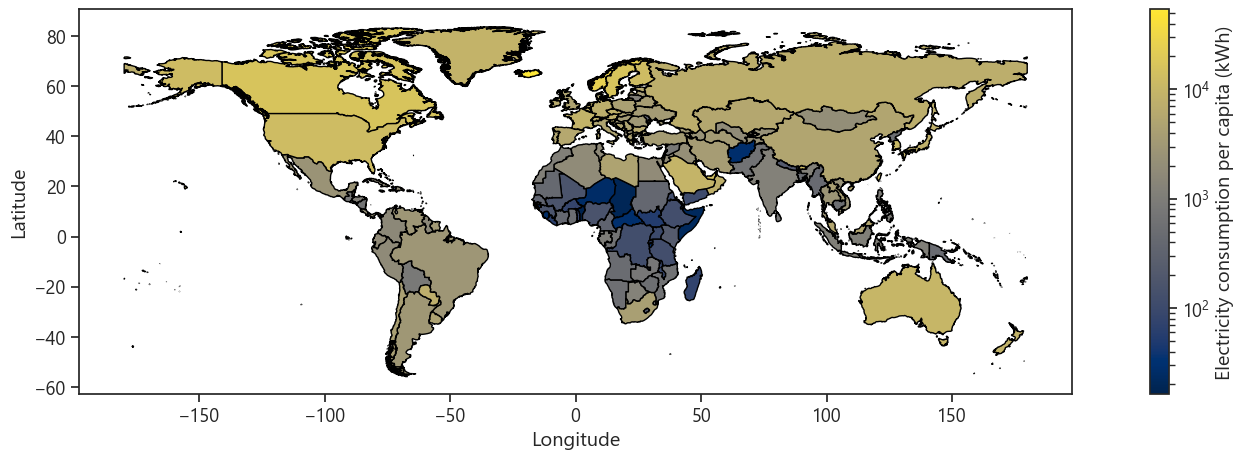

In [13]:
to_plot = countries.query('Year==2019').copy()
minval = to_plot.query('per_capita_electricity>0')['per_capita_electricity'].min()
maxval = to_plot.query('per_capita_electricity>0')['per_capita_electricity'].max()
cmap = cm.cividis
ax = to_plot.plot(
    figsize=(20, 5),
    column='per_capita_electricity',
    legend=True,
    legend_kwds={"label":"Electricity consumption per capita (kWh)"},
    norm=LogNorm(vmin=minval, vmax=maxval),
    cmap=cmap,
    edgecolor='black',
    missing_kwds={'color': 'lightgrey'},
    )
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_aspect(1)
plt.savefig('electricity_consumption_by_country_2019.png', dpi=300, bbox_inches='tight')

We can also see how much coal each country burns to generate electricity on a per capita basis. Australia is a clear outlier with a handful of other countries (China, the United States, South Africa, Kazakhstan, and some Eastern/Southeastern European countries) in a second usage tier.

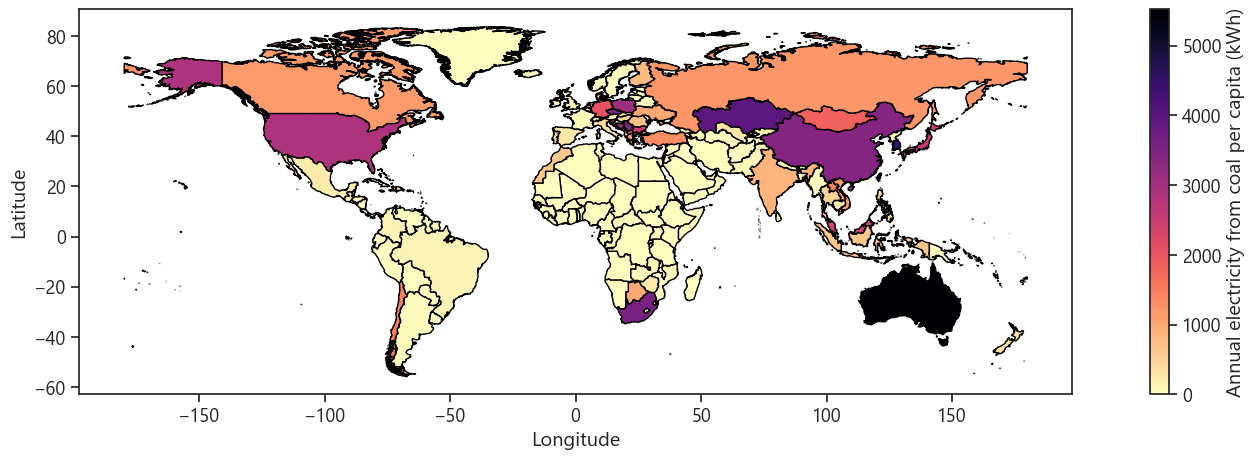

In [14]:
ax = to_plot.plot(
    figsize=(20, 5),
    column='coal_elec_per_capita',
    legend=True,
    legend_kwds={"label":'Annual electricity from coal per capita (kWh)'},
    cmap=cm.magma_r,
    edgecolor='black',
    missing_kwds={'color': 'lightgrey'},
    )
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_aspect(1)
plt.savefig('electricity_from_coal_by_country_2019.png', dpi=300, bbox_inches='tight')

Next let's look at annual deaths from outdoor air pollution per capita. There is some correlation between this plot and the previous one showing coal usage for electricity per capita (compare China and Eastern Europe), but there are plenty of places where outdoor air pollution is bad even though there is not much coal being used (Africa, the Middle East, etc.).

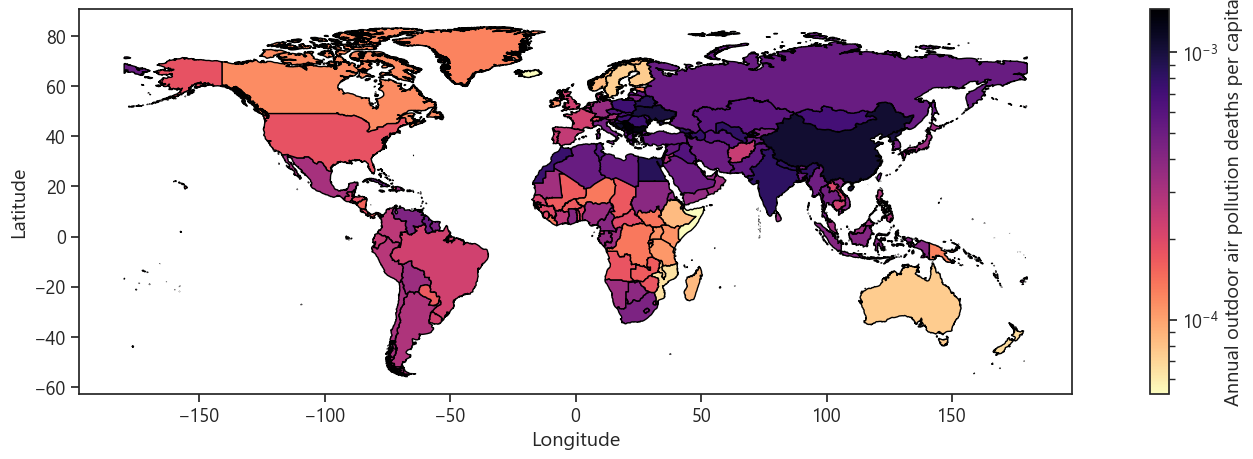

In [15]:
to_plot['Annual outdoor air pollution deaths per capita'] = to_plot['Deaths - Cause: All causes - Risk: Outdoor air pollution - OWID - Sex: Both - Age: All Ages (Number)']/to_plot['population']
minval = to_plot[to_plot['Annual outdoor air pollution deaths per capita']>0]['Annual outdoor air pollution deaths per capita'].min()
maxval = to_plot[to_plot['Annual outdoor air pollution deaths per capita']>0]['Annual outdoor air pollution deaths per capita'].max()
ax = to_plot.plot(
    figsize=(20, 5),
    column='Annual outdoor air pollution deaths per capita',
    legend=True,
    legend_kwds={"label":'Annual outdoor air pollution deaths per capita'},
    norm=LogNorm(vmin=minval, vmax=maxval),
    cmap=cm.magma_r,
    edgecolor='black',
    missing_kwds={'color': 'lightgrey'},
    )
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_aspect(1)
plt.savefig('deaths_from_outdoor_air_pollution_by_country_2019.png', dpi=300, bbox_inches='tight')

In [16]:
# Make a reduced data frame containing only the variables we want to use.
to_plot = countries[
    [
        'Deaths - Cause: All causes - Risk: Outdoor air pollution - OWID - Sex: Both - Age: All Ages (Number)',
        'Year',
        'coal_elec_per_capita',
        'solar_elec_per_capita',
        'renewables_share_elec',
        'fossil_share_elec',
        'population',
        'gdp',
        'NAME'
    ]
].copy()

# These are given as percentages, but I want them as fractions.
to_plot['fossil_share_elec'] /= 100
to_plot['renewables_share_elec'] /= 100

# Rename the columns to be more descriptive and give better axes labels.
coal_elec_per_capita = 'Annual electricity from coal per capita (kWh)'
solar_elec_per_capita = 'Annual electricity from solar per capita (kWh)'
renewables_share_elec = 'Fraction of electricity generation from renewable energy sources (kWh)'
fossil_share_elec = 'Fraction of electricity generation from fossil fuels (kWh)'
od_air_poll_deaths = 'Annual outdoor air pollution deaths per capita'
gdp_per_cap = 'Annual GDP per capita (USD)'
to_plot.rename(columns=\
    {
        'Deaths - Cause: All causes - Risk: Outdoor air pollution - OWID - Sex: Both - Age: All Ages (Number)':'Annual outdoor air pollution deaths',
        'coal_elec_per_capita':coal_elec_per_capita,
        'solar_elec_per_capita':solar_elec_per_capita,
        'renewables_share_elec':renewables_share_elec,
        'fossil_share_elec':fossil_share_elec,
    },
    inplace=True)

# Per capita measurements of air pollutions deaths are more useful than
# the raw numbers, because those would be distorted towards large
# countries. Similar for GDP.
to_plot[od_air_poll_deaths] = to_plot['Annual outdoor air pollution deaths']/to_plot['population']
to_plot[gdp_per_cap] = to_plot['gdp']/to_plot['population']

Let's make some more plots to investigate the degree to which deaths from outdoor air pollution are related to fossil fuel use. Because the total number of countries in the world is large, we will focus on analyzing data from the 6 most populous and richest countries. These are nearly mutually exclusive sets which is nice for comparative purposes. There are several very wealthy but very small countries with unusual economies that are not particularly representative (e.g. Qatar, Luxembourg, Singapore), so I am excluding any country with a population less than 10 million. I am also excluding Saudi Arabia becauase, while its population is greater than 10 million, as an oil exporter its electricity source mix is unusually skewed towards oil.

In [17]:
populous_country_names = to_plot.groupby(by='NAME').last().sort_values('population', ascending=False).iloc[:6].index
rich_country_names = to_plot[to_plot['population']>10000000].groupby(by='NAME').last().sort_values(gdp_per_cap, ascending=False).query('NAME!="Saudi Arabia"').iloc[:6].index
populous_countries = to_plot[to_plot['NAME'].isin(populous_country_names)].sort_values('population', ascending=False)
rich_countries = to_plot[to_plot['NAME'].isin(rich_country_names)].sort_values(gdp_per_cap, ascending=False)

print("Six most populous countries in the world:\n", *populous_country_names, sep='\n')
print("\nSix richest countries in the world (GDP per capita) with a population",
      "  greater than 10 million people (excl. Saudi Arabia):\n", *rich_country_names, sep='\n')

Six most populous countries in the world:

China
India
United States
Indonesia
Pakistan
Brazil

Six richest countries in the world (GDP per capita) with a population
  greater than 10 million people (excl. Saudi Arabia):

United States
Australia
Netherlands
Germany
Sweden
Canada


In [18]:
# These are monochrome Color Brewer color palettes that I will use to
# indicate change over time for each country.
palettes = ['Blues', 'Greens', 'Greys', 'Oranges', 'Purples', 'Reds']

In [19]:
# The default way in which Seaborn adds labels to ticks for log-scale
# axes is not great, so here I define a function to do a better job.
def make_new_tick_labels(major_ticks, minor_ticks, orig_lim):
    # For some reason, the list of ticks can include ticks which are
    # not in the display window, so I have to explicitly count how
    # many major ticks there are on the plot.
    n_major_ticks = np.sum([True if bisect_left(orig_lim, tick)==1 else False
                            for tick in major_ticks])
    # Depending on how many major ticks there are, label a certain set
    # of minor ticks. These are chosen to appear approximately evenly
    # spaced on a log scale.
    if n_major_ticks==0:
        which_minor_ticks = [2, 3, 4, 5, 6, 7, 8, 9]
    elif n_major_ticks<2:
        which_minor_ticks = [2, 3, 6]
    elif n_major_ticks==2:
        which_minor_ticks = [3]
    else:
        which_minor_ticks = []
    # Make the new tick labels by unpacking the floating-point
    # components of the tick locations.
    tick_labels = []
    for tick in minor_ticks:
        sign, digits, exponent = Decimal(tick).as_tuple()
        if sign==0:
            sign = ''
        elif sign==1:
            sign = '-'
        if len(digits)==1 or digits[1]==0:
            mantissa = digits[0]
        elif digits[1]==9:
            mantissa = digits[0] + 1
        exponent += len(digits)-1
        label = f'{sign}{mantissa}$\\times 10^'+'{'+str(exponent)+'}$'
        if mantissa in which_minor_ticks:
            tick_labels.append(label)
        else:
            tick_labels.append("")
    return tick_labels

In [20]:
# This function makes the primary scatter plot we will use in the correct
# styling.
def make_scatterplot(ax, data, x, y, country_names,
                     palettes, xscale, yscale):
    for i in range(len(country_names)):
        country = country_names[i]
        ax = sns.scatterplot(ax=ax,
                            data=data[data['NAME']==country],
                            x=x,
                            y=y,
                            hue="Year",
                            palette=palettes[i],
                            legend=False,
                            label=country)
        n_points_x = len(data[data['NAME']==country][x])
        n_points_y = len(data[data['NAME']==country][y])
        ax.scatter(
            x=[data[data['NAME']==country][x].iloc[int(n_points_x/2)]],
            y=[data[data['NAME']==country][y].iloc[int(n_points_y/2)]],
            c=[sns.color_palette(palettes[i], as_cmap=True)(0.5)],
            label=country)
    ax.set(xscale=xscale, yscale=yscale)
    if xscale=='log':
        orig_xlim = ax.get_xlim()
        new_xtick_labels = make_new_tick_labels(ax.get_xticks(),
                                                ax.get_xticks(minor=True),
                                                orig_xlim)
        ax.set_xticks(ax.get_xticks(minor=True),
                      labels=new_xtick_labels, minor=True, size='small')
        ax.set_xlim(orig_xlim)
    if yscale=='log':
        orig_ylim = ax.get_ylim()
        new_ytick_labels = make_new_tick_labels(ax.get_yticks(),
                                                ax.get_yticks(minor=True),
                                                orig_ylim)
        ax.set_yticks(ax.get_yticks(minor=True), labels=new_ytick_labels,
                      minor=True, size='small')
        ax.set_ylim(orig_ylim)

In [21]:
# This function calls the previous one twice to create the subplots of
# the most populous and richest countries
def make_scatterplots(x, y, palettes, xscale, yscale, filename):
    _, axes = plt.subplots(1, 2, figsize=(20, 5))
    make_scatterplot(axes[0], populous_countries, x, y, populous_country_names, palettes, xscale, yscale)
    make_scatterplot(axes[1], rich_countries, x, y, rich_country_names, palettes, xscale, yscale)
    handles, labels = axes[0].get_legend_handles_labels()
    axes[0].legend(
        handles=handles[1::2],
        labels=labels[1::2],
        # loc='center left',
        # bbox_to_anchor=(1, 0.5)
    )
    axes[0].set_title('Most populous countries')
    handles, labels = axes[1].get_legend_handles_labels()
    axes[1].legend(
        handles=handles[1::2],
        labels=labels[1::2],
        # loc='center left',
        # bbox_to_anchor=(1, 0.5)
    )
    axes[1].set_title('Richest countries with population > 10 million (excl. Saudi Arabia)')
    plt.savefig(filename, dpi=300, bbox_inches='tight')

Below we see a series of plots comparing the annual number of deaths per capita from outdoor air pollution to a variety of metrics, mostly related to electricity production. However, before we start looking at those comparisons, I want to show this plot that motivates what I said above: that the most populous countries are generally not the wealthiest countries. They basically fall into three categories, with China, Indonesia, and Brazil having achieved essentially middle-income status, while India and Pakistan are still relatively poor (but getting richer quickly, particularly India!) and the US is much wealthier than the rest. Among the rich countries, we see that they are all pretty much the same, with the US (and to a lesser extent Australia) being a bit wealthier than the rest.

It's also instructive to look at the scales of the x-axes. The wealthy countries are all within ~20% of each other in GDP per capita, while Brazil, Indonesia, and China are all more than twice as wealthy as India and Pakistan. 

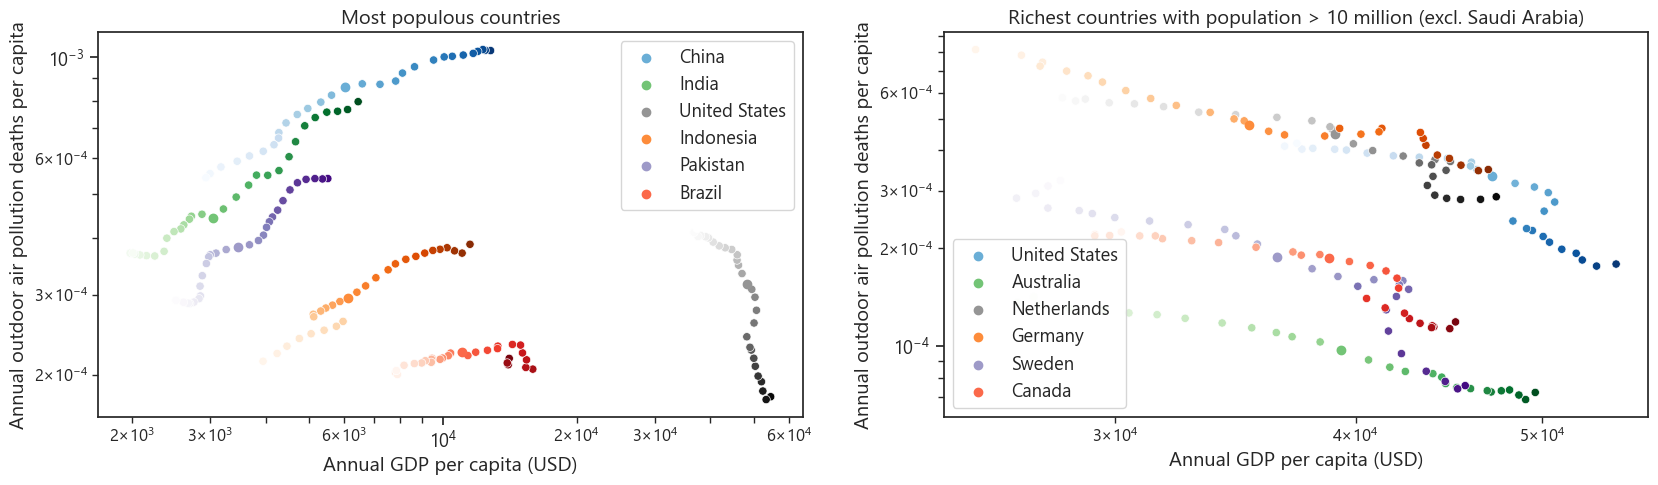

In [22]:
make_scatterplots(
    gdp_per_cap,
    od_air_poll_deaths,
    palettes,
    'log',
    'log',
    'air_poll_deaths_vs_gdp.png')

plt.show()

Now we'll look at the relationships that outdoor air pollution deaths have with different electricity production metrics.

The first plot compares to the annual amount of electricity generated per capita from coal. One might expect that this would be correlated with deaths from outdoor air pollution, and ideed we see that this is the case for both populous and rich countries. The lightness of color for each country shows the progression over time, with later years being darker. We can see that, apart from the US, the most populous countries in the world have mostly seen increasing deaths from outdoor air pollution over time, which mostly corresponds to an increase in electricity generation from coal. The rich countries are doing the opposite: reducing their coal electricity generation and simultaneously reducing their rates of outdoor air pollution deaths. The Netherlands are somewhat of an outlier among the rich countries, as they seem to be increasing their coal electricity generation over time, but this has not yet lead to an increase in air pollution deaths. It turns out that there are factors besides coal electricity generation that affect air pollution deaths!

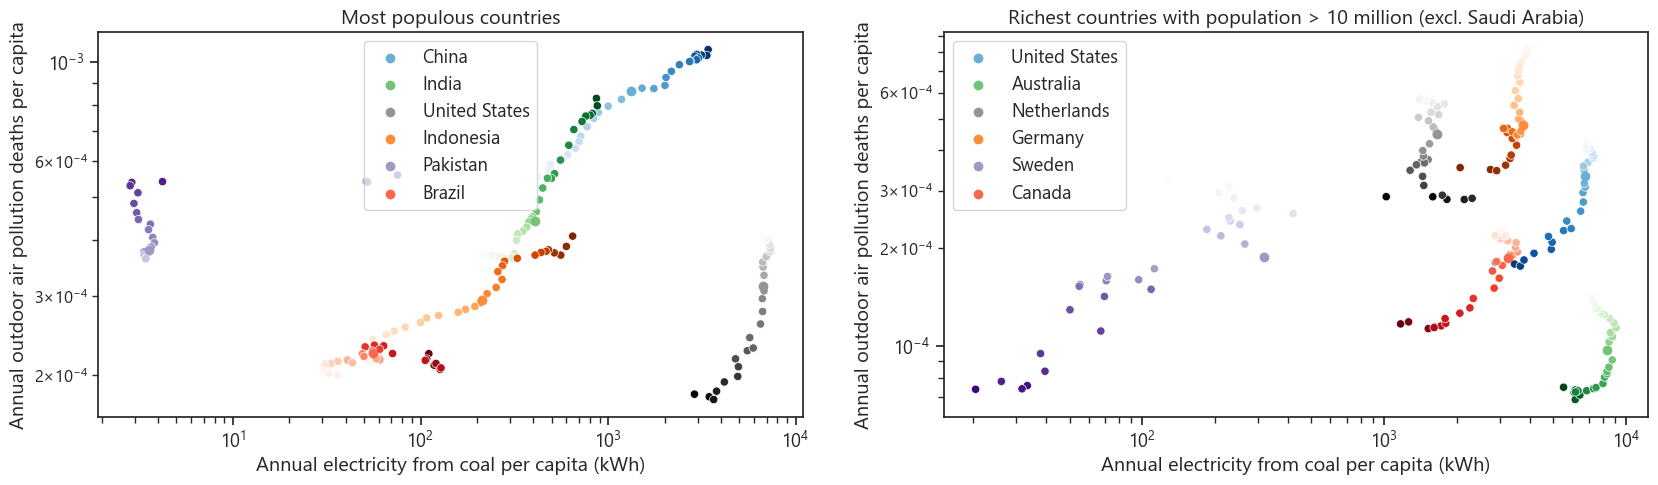

In [23]:
make_scatterplots(
    coal_elec_per_capita,
    od_air_poll_deaths,
    palettes,
    'log',
    'log',
    'air_poll_deaths_vs_coal_cons.png')

plt.show()

The second plot make the same comparison with solar electricity generation per capita. Here we see that both groups of countries are deploying more solar power, but this is of course not correlated with a decrease in deaths from outdoor air pollution in the populous countries. Building out renewables is not enough; we need to reduce emissions!

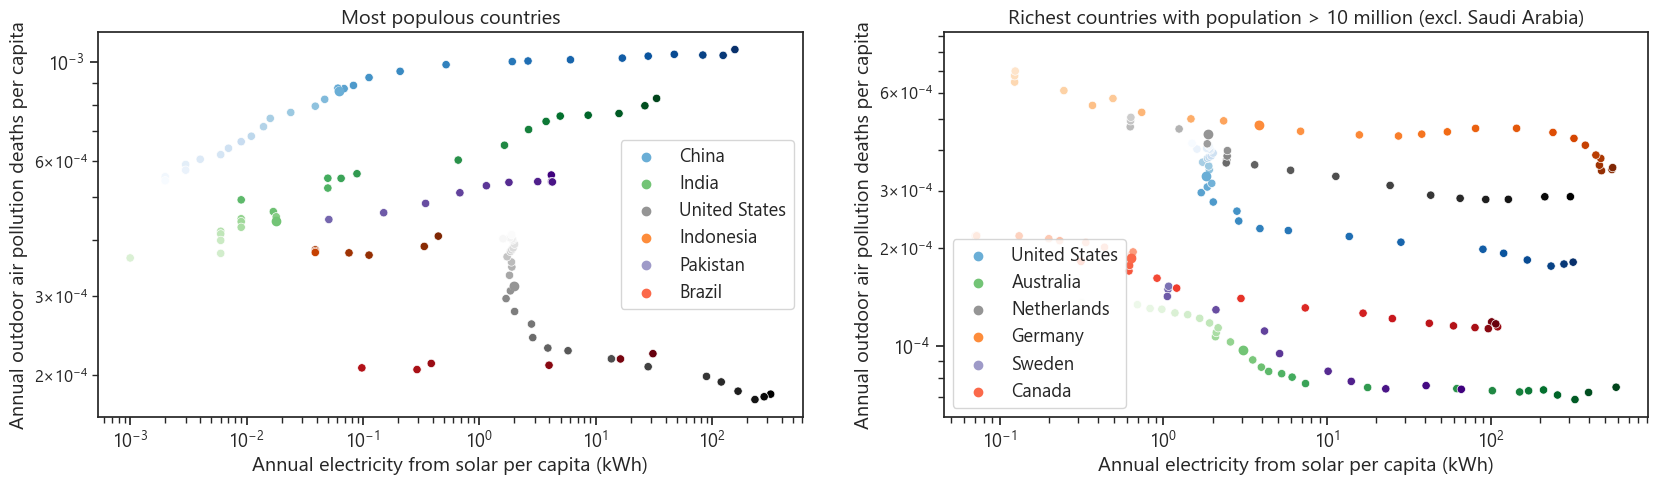

In [24]:
make_scatterplots(
    solar_elec_per_capita,
    od_air_poll_deaths,
    palettes,
    'log',
    'log',
    'air_poll_deaths_vs_solar_cons.png')

plt.show()

If we compare to the fraction of electricity that is generated by fossil fuels, we see somewhat different relationships. I'll note that these plots have a logisticly scaled x-axis to better show the behavior of countries with either very high or very low fractions of fossil fuel electricity generation.

Even though China is increasing its coal usage for electricity, it is simultaneously reducing the fraction of its electricity that comes from fossil fuels. This is because it is building renewables even faster! We see that most of the other populous countries are mostly holding steady in fossil fuel use, with the exceptions of the US and Brazil. Brazil is unfortunately increasing its fossil fuel use, although it is important to note that this is from an incredibly low baseline.

The rich countries are all reducing their fossil fuel use overall, but there is wide variation in where they are in that process. Sweden has a nearly completely clean grid, while the Netherlands and Australia have comparitvely dirty grids.

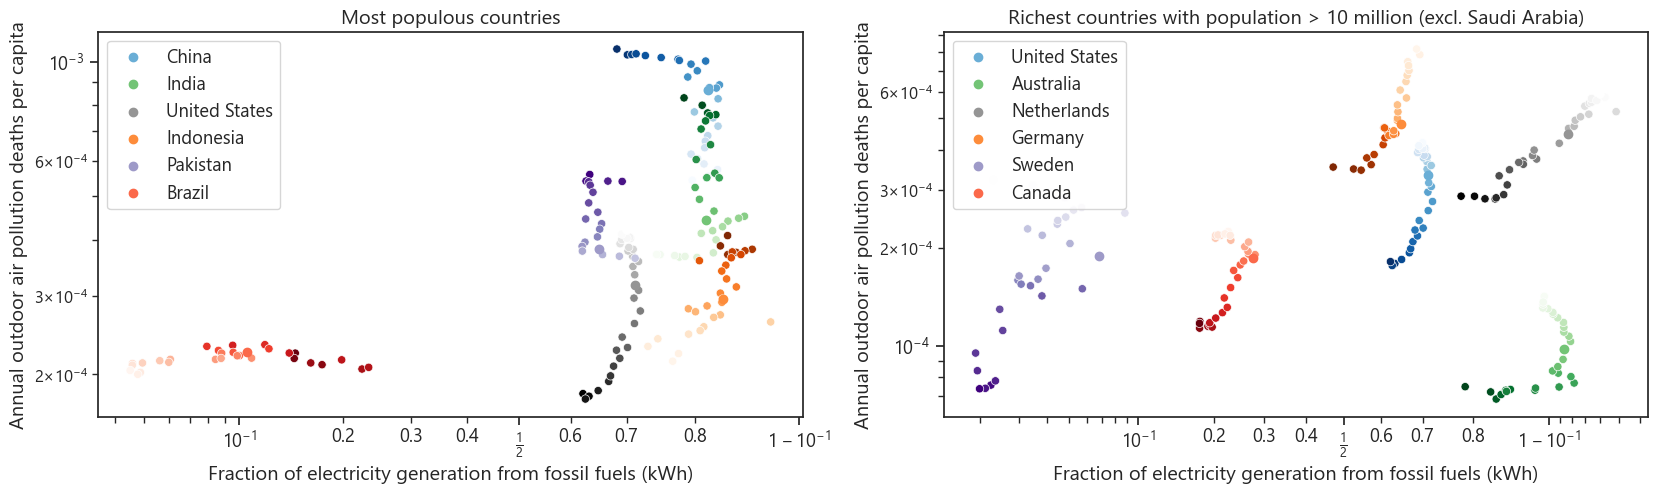

In [25]:
make_scatterplots(
    fossil_share_elec,
    od_air_poll_deaths,
    palettes,
    'logit',
    'log',
    'air_poll_deaths_vs_fossil_share.png')

plt.show()

Finally let's compare to the fraction of electricity generated from renewable energy sources. Again, I plot the x-axis on a logistic scale. These are basically just inverses of the previous plots. We can see that the Netherlands and Germany have really scaled their renewable energy over the past 30 years or so, while other countries have been slower.

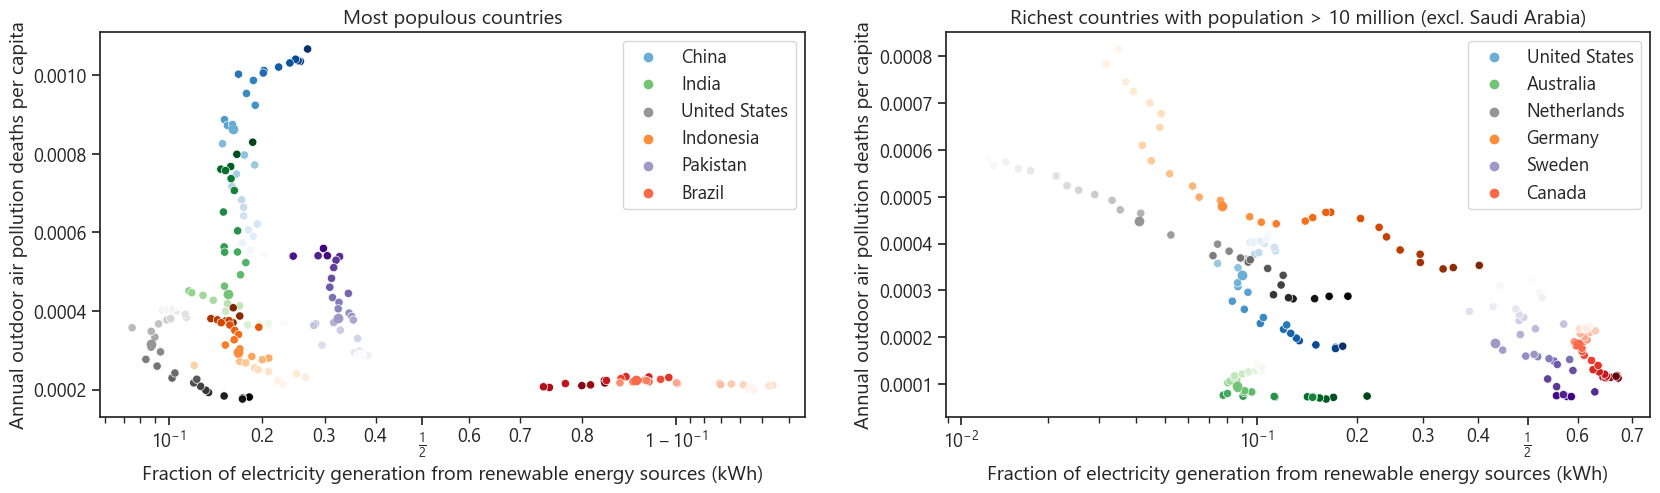

In [26]:
make_scatterplots(
    renewables_share_elec,
    od_air_poll_deaths,
    palettes,
    'logit',
    'linear',
    'air_poll_deaths_vs_renewables_share.png')

plt.show()

### Extracting some numbers from the above plots

Some of the relationships in the above plots look vaguely linear, so let's see if we can successfully apply that hypothesis to the rest of our data set. First we'll take a look at the relationship between the share of electricity generated from fossil fuels and the number of deaths from outdoor air pollution per capita. Because the plot we made showing this relationship had log-logistic axes, the relationship in linear space is complicated. Suffice it to say that a positive slope (in the log-logistic space) indicates that deaths from outdoor air pollution generally go up when the fraction of electricty from fossil fuels increases, and a negative slope indicates the reverse. I plot only those countries that had sufficient data to perform a fit that returned a nonzero slope with a p-value less than 0.1. Countries that do not meet these criteria are shown in gray. I'm using a relatively high p-value because this is not a particularly rigorious study and we are more interested in seeing possible relationships than quantifying anything.

In [27]:
all_countries = to_plot['NAME'].unique()

In [28]:
fossil_death_df = to_plot.copy()
# Get rid of infinities and NaNs
fossil_death_df = fossil_death_df[(~np.isinf(fossil_death_df[fossil_share_elec]))&(~fossil_death_df[fossil_share_elec].isna())]
fossil_death_slope = {'NAME':[], 'slope':[]}
with warnings.catch_warnings(): #If we don't do this there are a bunch of benign warnings that get printed
    warnings.simplefilter("ignore")
    for country in all_countries:
        #Fit a linear function against the logit of the fraction of electricity from fossil fuels
        X = sm.add_constant(scipy.special.logit(fossil_death_df[fossil_death_df['NAME']==country][fossil_share_elec]))
        try:
            model = sm.OLS(fossil_death_df[fossil_death_df['NAME']==country][od_air_poll_deaths], X)
        except (MissingDataError, ValueError):
            fossil_death_slope['NAME'].append(country)
            fossil_death_slope['slope'].append(np.nan)
            continue
        try:
            res = model.fit()
        except np.linalg.LinAlgError:
            fossil_death_slope['NAME'].append(country)
            fossil_death_slope['slope'].append(np.nan)
            continue
        # Only save the results of countries where we get a significant and nonzero value for the slope
        if res.params[1]!=0 and res.pvalues[1]<0.1:
            fossil_death_slope['NAME'].append(country)
            fossil_death_slope['slope'].append(res.params[1])
        else:
            fossil_death_slope['NAME'].append(country)
            fossil_death_slope['slope'].append(np.nan)

In [29]:
fossil_death_slope = pd.DataFrame(fossil_death_slope)

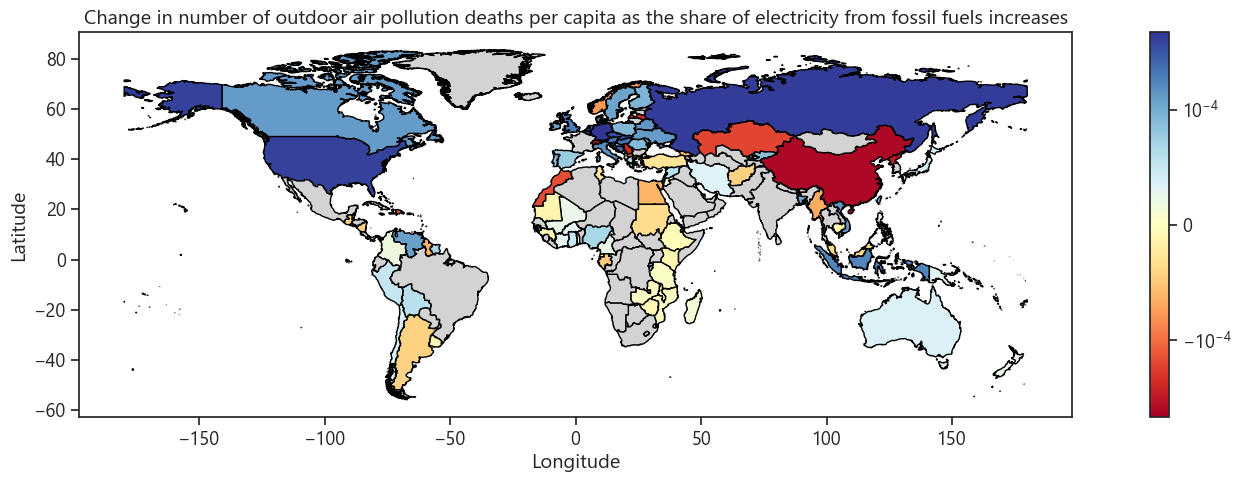

In [30]:
to_plot2 = countries[countries['Year']==2018]
to_plot2 = pd.merge(to_plot2, pd.DataFrame(fossil_death_slope), on='NAME')
cmap = cm.RdYlBu
maxval = abs(to_plot2['slope']).max()
ax = to_plot2.plot(
    figsize=(20, 5),
    column='slope',
    legend=True,
    cmap=cmap,
    missing_kwds={'color': 'lightgrey'},
    norm=SymLogNorm(1e-4, vmin=-maxval, vmax=maxval),
    edgecolor='black',
    )
ax.set_title('Change in number of outdoor air pollution deaths per capita as the share of electricity from fossil fuels increases')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_aspect(1)
plt.savefig('air_poll_deaths_slope_fossil_share.png', dpi=300, bbox_inches='tight')
plt.show()

In my opinion, the above figure shows that, in general, weathier countries see a positive relationship between fossil fuel electricity share and deaths from outdoor air pollution. I.e. deaths decrease as fossil fuel use decreases. In particular, I am looking at Europe, North America, and Australia/New Zealand. There are a few outliers in that group, namely Norway, Latvia, Switzerland, Serbia, and North Macedonia. Conversely, many countries in the developing world have a negative relationship between these two variables. I suspect that this is probably related to the fact that as they develop, they are simultaneously increasing fossil fuel usage and improving their public health and healthcare so that illnesses from outdoor air pollution are less likely to be fatal.

Let's see to what degree this relationship between this slope and a country's wealth holds up. Below I plot these slopes against each country's GDP per capita.

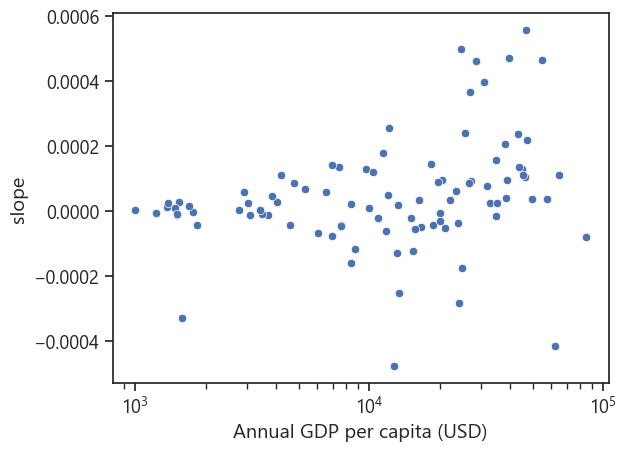

In [31]:
to_plot2[gdp_per_cap] = to_plot2['gdp']/to_plot2['population']
t1 = to_plot2.dropna(subset=[gdp_per_cap, 'slope'])
ax = sns.scatterplot(data=t1, x=gdp_per_cap, y='slope')
ax.set(xscale="log")
plt.savefig('fossil_death_slope_vs_gdp.png', dpi=300, bbox_inches='tight')
plt.show()

We can see that there is some relationship between the two, primarily for countries with a GDP per capita above ~$30,000 per year.

Now let's look at the relationship between each country's annual electricity generation from coal and the number of deaths from outdoor air pollution per capita. Again, I plot only those countries that had sufficient data to perform a fit that returned a nonzero slope with a p-value less than 0.1. Countries that do not meet these criteria are shown in gray.

In [32]:
coal_death_df = fossil_death_df.copy()
coal_death_slope = {'NAME':[], 'slope':[]}
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for country in all_countries:
        X = sm.add_constant(np.log(coal_death_df[coal_death_df['NAME']==country][coal_elec_per_capita]))
        try:
            model = sm.OLS(np.log(coal_death_df[coal_death_df['NAME']==country][od_air_poll_deaths]), X)
        except (MissingDataError, ValueError):
            coal_death_slope['NAME'].append(country)
            coal_death_slope['slope'].append(np.nan)
            continue
        try:
            res = model.fit()
        except np.linalg.LinAlgError:
            coal_death_slope['NAME'].append(country)
            coal_death_slope['slope'].append(np.nan)
            continue
        if res.pvalues[1]<0.1 and res.params[1]!=0:
            coal_death_slope['NAME'].append(country)
            coal_death_slope['slope'].append(res.params[1])
        else:
            coal_death_slope['NAME'].append(country)
            coal_death_slope['slope'].append(np.nan)

In [33]:
coal_death_slope = pd.DataFrame(coal_death_slope)

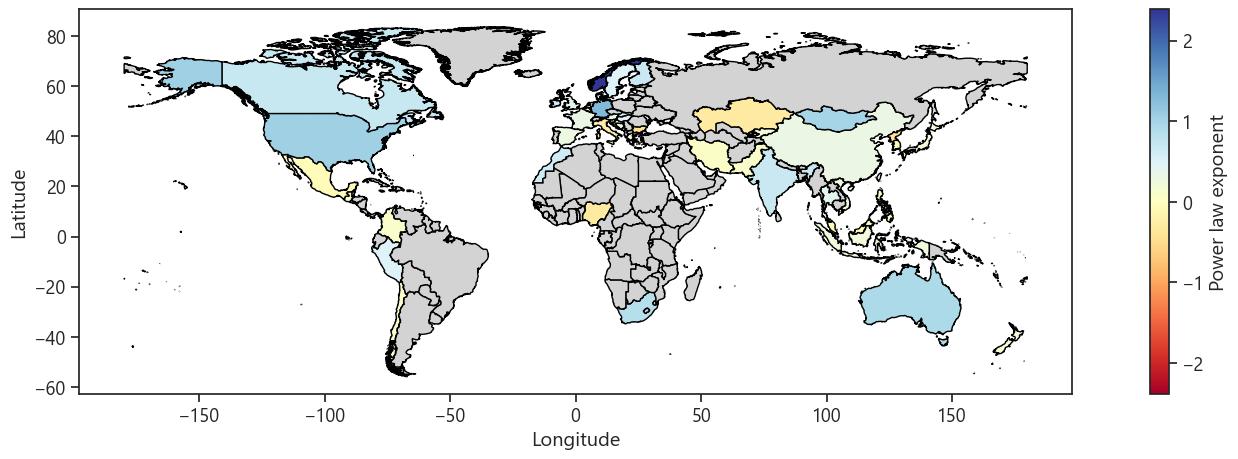

In [34]:
to_plot3 = countries[countries['Year']==2018]
to_plot3 = pd.merge(to_plot3, coal_death_slope, on='NAME')
cmap = cm.RdYlBu
maxval = abs(to_plot3['slope']).max()
ax = to_plot3.plot(
    figsize=(20, 5),
    column='slope',
    legend=True,
    cmap=cmap,
    missing_kwds={'color': 'lightgrey'},
    legend_kwds={"label":"Power law exponent"},
    # norm=SymLogNorm(1e0, vmin=-maxval, vmax=maxval),
    vmin=-maxval,
    vmax=maxval,
    edgecolor='black',
    )
# ax.set_title('Change in number of deaths from outdoor air pollution per TWh increase in electricity from coal')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_aspect(1)
plt.savefig('air_poll_deaths_slope_coal_cons.png', dpi=300, bbox_inches='tight')
plt.show()

Here we see that most countries have a positive relationship between coal electricity generation and deaths from outdoor air pollution. Norway is clearly an outlier, and several countries with apparently negative power-law exponents are also outliers. Below I show a plot comparing some of those countries.

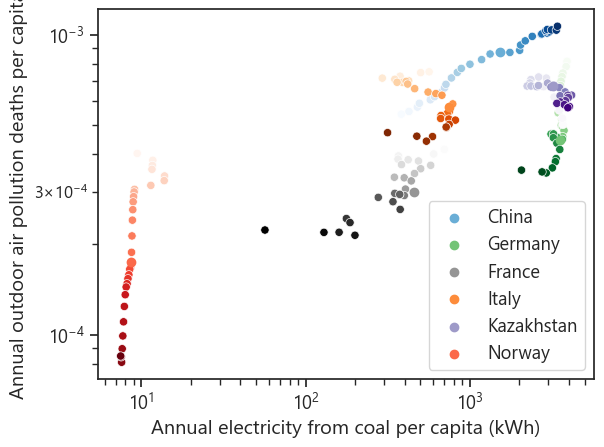

In [35]:
make_scatterplot(None, to_plot, coal_elec_per_capita, od_air_poll_deaths, ['China', 'Germany', 'France', 'Italy', 'Kazakhstan', 'Norway'], palettes, 'log', 'log')
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(
    handles=handles[1::2],
    labels=labels[1::2],
)
plt.show()

We see that Norway is an outlier because it has had very little coal in its electricity generation mix for the entirety of this data set. That, combined with its great strides in reducing deaths from air pollution, mean that the slope of this relationship is very large for Norway. Italy and Kazakhstan are also outliers on this plot in that they have negative slopes. For Italy we can see that, even though its fitted slope apparently has a p-value < 0.1, its evolution over time does not seem to be particularly linear. Kazakhstan does seem to be reducing air pollution deaths while increasing its coal usage, perhaps because it is still a developing country.